In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import librosa
import librosa.display
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Look at the Test Set

In [3]:
dict_genres = {'Blues':0, 'Classical':1, 'Country':2, 'Disco':3, 'Hip-Hop':4, 'Jazz':5, 'Metal':6, 'Pop':7, 'Reggae':8, 'Rock':9}

In [4]:
# Tree_7
model_root = load_model('models/tree_7/model_finals/model_root.h5')
model_root_f1 = load_model('models/tree_7/model_finals/model_root_f1.h5')
model_root_f1_1 = load_model('models/tree_7/model_finals/model_root_f1_1.h5')
model_root_f1_2 = load_model('models/tree_7/model_finals/model_root_f1_2.h5')
model_root_f1_2_1 = load_model('models/tree_7/model_finals/model_root_f1_2_1.h5')
model_root_f2 = load_model('models/tree_7/model_finals/model_root_f2.h5')
model_root_f2_1 = load_model('models/tree_7/model_finals/model_root_f2_1.h5')
model_root_f2_1_1 = load_model('models/tree_7/model_finals/model_root_f2_1_1.h5')
model_root_f2_2 = load_model('models/tree_7/model_finals/model_root_f2_2.h5')

In [4]:
# Tree_8
model_root = load_model('models/tree_8/model_finals/model_root.h5')
model_root_f1 = load_model('models/tree_8/model_finals/model_root_f1.h5')
model_root_f1_1 = load_model('models/tree_8/model_finals/model_root_f1_1.h5')
model_root_f1_2 = load_model('models/tree_8/model_finals/model_root_f1_2.h5')
model_root_f1_2_1 = load_model('models/tree_8/model_finals/model_root_f1_2_1.h5')
model_root_f2 = load_model('models/tree_8/model_finals/model_root_f2.h5')
model_root_f2_1 = load_model('models/tree_8/model_finals/model_root_f2_1.h5')
model_root_f2_1_1 = load_model('models/tree_8/model_finals/model_root_f2_1_1.h5')
model_root_f2_2 = load_model('models/tree_8/model_finals/model_root_f2_2.h5')

In [5]:
npzfile = np.load('data/all_targets_sets_test_new.npz')
print(npzfile.files)

X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(1000, 128, 128) (1000, 10)


In [6]:
y_test = np.argmax(y_test, axis= -1)

In [7]:
y_true = np.copy(y_test)

In [8]:
X_test = np.expand_dims(X_test, axis = -1)

In [9]:
print(X_test.shape, y_test.shape, y_true.shape)

(1000, 128, 128, 1) (1000,) (1000,)


In [10]:
class ModelNodeTree():
    def __init__(self, model, left, right, translate = None):
        self._model = model
        self._left = left
        self._right = right
        self._translate = translate
        
    def predict(self, batch):
        y = self._model.predict(batch)
        y = np.argmax(y, axis=-1)
        y_copy = np.copy(y)
        
        if self._translate is not None:
            for k, t in self._translate.items():
                y[y_copy == t] = k
        else:
            if np.sum(y_copy == 0) > 0:
                if type(self._left) == int:
                    y[y_copy == 0] = self._left
                else:
                    y[y_copy == 0] = self._left.predict(batch[y_copy == 0])

            if np.sum(y_copy == 1) > 0:
                if type(self._right) == int:
                    y[y_copy == 1] = self._right
                else:
                    y[y_copy == 1] = self._right.predict(batch[y_copy == 1])
        
        return y

In [11]:
# Test_7
f2_2 = ModelNodeTree(model_root_f2_2, 7, 3)
f2_1_1 = ModelNodeTree(model_root_f2_1_1, 9, 2)
f2_1 = ModelNodeTree(model_root_f2_1, f2_1_1, 6)
f2 = ModelNodeTree(model_root_f2, f2_1, f2_2)

f1_2_1 = ModelNodeTree(model_root_f1_2_1, 5, 0)
f1_2 = ModelNodeTree(model_root_f1_2, f1_2_1, 1)
f1_1 = ModelNodeTree(model_root_f1_1, 8, 4)
f1 = ModelNodeTree(model_root_f1, f1_1, f1_2)

root = ModelNodeTree(model_root, f1, f2)

In [11]:
# Test_8
f2_2 = ModelNodeTree(model_root_f2_2, 6, 1)
f2_1_1 = ModelNodeTree(model_root_f2_1_1, 7, 3)
f2_1 = ModelNodeTree(model_root_f2_1, f2_1_1, 4)
f2 = ModelNodeTree(model_root_f2, f2_1, f2_2)

f1_2_1 = ModelNodeTree(model_root_f1_2_1, 8, 0)
f1_2 = ModelNodeTree(model_root_f1_2, f1_2_1, 5)
f1_1 = ModelNodeTree(model_root_f1_1, 9, 2)
f1 = ModelNodeTree(model_root_f1, f1_1, f1_2)

root = ModelNodeTree(model_root, f1, f2)

In [12]:
y_pred = root.predict(X_test)

In [13]:
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

(1000,) (1000,)
              precision    recall  f1-score   support

       Blues       0.90      0.86      0.88       100
   Classical       0.92      0.87      0.89       100
     Country       0.69      0.65      0.67       100
       Disco       0.63      0.66      0.64       100
     Hip-Hop       0.89      0.87      0.88       100
        Jazz       0.85      0.91      0.88       100
       Metal       0.93      0.87      0.90       100
         Pop       0.69      0.73      0.71       100
      Reggae       0.80      0.79      0.79       100
        Rock       0.62      0.66      0.64       100

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



Text(91.68, 0.5, 'predicted label')

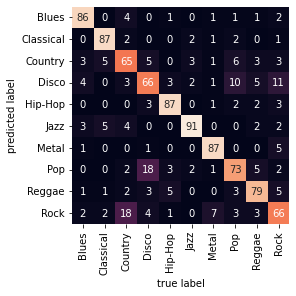

In [14]:
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [15]:
print(accuracy_score(y_true, y_pred))

0.787


### TEST SINGOLI

In [19]:
def create_spectogram(AUDIO_DIR):
    y, sr = librosa.load(AUDIO_DIR)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [20]:
def plot_spect(AUDIO_DIR):
    spect = create_spectogram(AUDIO_DIR)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [85]:
#AUDIO_DIR = 'demo/Nirvana - Smells Like Teen Spirit.mp3'
#AUDIO_DIR = 'demo/Maroon 5 - She Will Be Loved.mp3'
#AUDIO_DIR = 'demo/Giovanni Allevi - Ti Scrivo.mp3'
#AUDIO_DIR = 'demo/Zucchero - Vedo nero.mp3'
AUDIO_DIR = 'demo/Francesco De Gregori - Buonanotte Fiorellino.mp3'

In [86]:
spect = create_spectogram(AUDIO_DIR)
#spect = spect[:128, :]

In [87]:
spect_raw = librosa.core.db_to_power(spect, ref=1.0)
spect = np.log(spect_raw)

print(np.amin(spect_raw), np.amax(spect_raw), np.mean(spect_raw))

1e-08 1.0 0.0028222431


In [88]:
spect = np.expand_dims(spect, axis = -1)
#spect = np.expand_dims(spect, axis = 0)
spect.shape

(2734, 128, 1)

In [89]:
_arr = []
for i in range(spect.shape[0]//128):
    frame = spect[128*i:128*(i+1), :]
    if frame.shape[0] == 128:
        _arr.append(frame)
#        print("ok")
#    print(str(128*i)+":"+str(128*(i+1)))
#    print(frame.shape)
    
_arr = np.array(_arr)

In [90]:
_arr.shape

(21, 128, 128, 1)

In [91]:
y_pred_single = root.predict(_arr)
#print(list(dict_genres.keys())[list(dict_genres.values()).index(y_pred_single[0])])

In [92]:
y_pred_single

array([5, 8, 8, 5, 2, 9, 2, 9, 9, 2, 9, 2, 9, 2, 2, 9, 2, 2, 0, 2, 5],
      dtype=int64)

In [93]:
result = np.zeros(10, dtype="int64")

In [94]:
for i in range(y_pred_single.shape[0]):
    prediction = y_pred_single[i]
    result[prediction] += 1

print(list(dict_genres.keys())[np.argmax(result)])

Country


In [95]:
for i in range(10):
    print(str(list(dict_genres.keys())[i])+": "+str(result[i]))


Blues: 1
Classical: 0
Country: 9
Disco: 0
Hip-Hop: 0
Jazz: 3
Metal: 0
Pop: 0
Reggae: 2
Rock: 6


In [42]:
i=0

print(list(dict_genres.keys())[list(dict_genres.values()).index(y_true[i])])

y_pred_single = root.predict(np.array([X_test[i]]))
print(list(dict_genres.keys())[list(dict_genres.values()).index(y_pred_single[0])])

Rock
Pop


In [21]:
#dict_genres = {'Blues':0, 'Classical':1, 'Country':2, 'Disco':3, 'Hip-Hop':4, 'Jazz':5, 'Metal':6, 'Pop':7, 'Reggae':8, 'Rock':9}
i = 200
y_test[i]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
model_root.predict(np.array([X_test[i]]))

array([[0.00975109, 0.99024886]], dtype=float32)